# Initialization

In [10]:
import stimulator_calibration_lib as csl
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [11]:
h        = 4.135667E-15 # Planck's constant [eV*s]
c        = 299792458    # speed of light [m/s]
eV_per_J = 6.242E+18    # [eV] per [J]

# Definitions
### Load opsin spectra from file:

*TODO: Add some information about how the file(s) are organized*

In [12]:
x_wavelen_nm = np.loadtxt("mouse_cone_opsins.txt", usecols=(2,))
mouseMOpsin  = np.loadtxt("mouse_cone_opsins.txt", usecols=(1,))
mouseSOpsin  = np.loadtxt("mouse_cone_opsins.txt", usecols=(0,))

*TODO: Load dicroic spectrum*

### Define photoreceptor- and species specific constants:

*   `ac_um2`<br />
    Cone OS light collection area in [µm^2], see [Nikonov et al., 2006](http://www.ncbi.nlm.nih.gov/pubmed/16567464) for details. This is an experimentally determined value, e.g. for wt mouse cones that is fully dark-adapted, a value of 0.2 can be assumed.
*   `ar_um2`<br />
    Rod OS light collection area, see above. A value of 0.5 is realistic.   


In [13]:
ac_um2 = 0.2     
ar_um2 = 0.5

### Define photoreceptors:

In [14]:
MCone = {"name"           : "mouse M cone",
         "peak_nm"        : 511,
         "collecArea_um2" : ac_um2, 
         "spect"          : mouseMOpsin}
SCone = {"name"           : "mouse S cone",
         "peak_nm"        : 360,         
         "collecArea_um2" : ac_um2, 
         "spect"          : mouseSOpsin}
Rod   = {"name"           : "mouse rod",
         "peak_nm"        : 510,         
         "collecArea_um2" : ar_um2, 
         "spect"          : []}

PRs   = [MCone, SCone, Rod]

### Define Stimulus LEDs:

*   `peak_nm`, peak wavelengths of stimulus LED(s) in [nm]          
*   `bandwidth_nm`, LED band width(s) in [nm]. If 0 then the LED's spectrum is expected to be contained in `spect` (same x range as the opsin spectra, see above, and with 1-nm resolution). Otherwise, the spectrum `spect` will be calculated.
*   `pow_meas_nW[]`, series of power measurements for this LED, in [nW], at the LED levels given in `levels` (0..255).

*TODO: Details about how to measure and that this is an approximation ...*

In [15]:
GrLED_pow = np.array([0.0,42.0])
GrLED_lev = np.array([0,255])
BlLED_pow = np.array([0.0,42.0])
BlLED_lev = np.array([0,255])

GrLED = {"name"         : "green",
         "peak_nm"      : 578,
         "bandwidth_nm" : 10,
         "spect"        : [],
         "pow_meas_nW"  : GrLED_pow,
         "levels"       : GrLED_lev}
BlLED = {"name"         : "blue",
         "peak_nm"      : 405,
         "bandwidth_nm" : 10,
         "spect"        : [],
         "pow_meas_nW"  : BlLED_pow,
         "levels"       : BlLED_lev}

LEDs  = [GrLED, BlLED]

### Define diameter of stimulus spot on detector:

In [16]:
r_spot_mm    = 0.250

# Calculate area of spot on the detector
#
A_detect_um2 = np.pi *(r_spot_mm *1E3)**2
print("Illuminated area is {0:.3e} µm2".format(A_detect_um2))

Illuminated area is 1.963e+05 µm2


# Calculation:


In [17]:
# Handle photoreceptor and LED spectra ...
#
# Determin minimum and maximum wavelength of the given opsin spectra for
# the generation of the respective LED/filter spectra, assuming a spectral
# resolution of 1 nm
#
spectWidth  = len(x_wavelen_nm)
spectMin_nm = x_wavelen_nm[0]
spectMax_nm = x_wavelen_nm[spectWidth -1]

# If LED/filter spectra are not define, generate those from center 
# wavelength and band-pass width
#
for LED in LEDs:
    # Generate spectrum for bandpass filter
    #
    if len(LED["spect"]) == 0:
        temp = []
        x1   = LED["peak_nm"] -LED["bandwidth_nm"]/2.0
        x2   = LED["peak_nm"] +LED["bandwidth_nm"]/2.0
        for i in range(spectWidth):
            temp.append(int(((i +spectMin_nm) > x1) and ((i +spectMin_nm) < x2)))
        LED["spect"] = np.array(temp)
    
    # Calculate overlap between each LED/filter and photoreceptor type
    #
    LED["effect_on_PR"] = []
    for PR in PRs:
        if len(PR["spect"]) > 0:
            temp = {}
            temp["PR_name"] = PR["name"]
            temp["spect"]   = PR["spect"] *LED["spect"]
            A_PR            = np.trapz(PR["spect"])
            A_overlap       = np.trapz(temp["spect"])
            temp["rel_exc"] = A_overlap/A_PR
            LED["effect_on_PR"].append(temp)


Relative co-excitation:
   1.4% of mouse M cone by green
   0.0% of mouse S cone by green
   1.0% of mouse M cone by blue
   2.7% of mouse S cone by blue


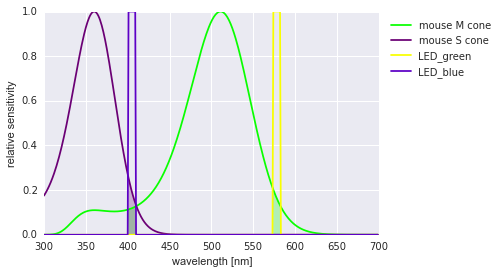

In [18]:
# Plot spectra of photoreceptors and LED/filter combinations
#
for PR in PRs:
    if len(PR["spect"]) > 0:
        plt.plot(x_wavelen_nm, PR["spect"], 
                 color=csl.wavelength_to_rgb(PR["peak_nm"]), label=PR["name"])
        
for LED in LEDs:        
    if len(LED["spect"]) > 0:    
        colLED = csl.wavelength_to_rgb(LED["peak_nm"])
        plt.plot(x_wavelen_nm, LED["spect"], color=colLED, label="LED_" +LED["name"])
        for effect in LED["effect_on_PR"]:
            for PR in PRs:
                if PR["name"] == effect["PR_name"]:
                    colPR = csl.wavelength_to_rgb(PR["peak_nm"])
            plt.fill(x_wavelen_nm, effect["spect"], facecolor=colPR, alpha=0.25)    

sns.axlabel("wavelength [nm]", "relative sensitivity")     
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

"""
# ***********************
# ***********************
LEDs[0]["effect_on_PR"][0]["rel_exc"] = 0.166864675438927
LEDs[0]["effect_on_PR"][1]["rel_exc"] = 1.08647022352287E-08
LEDs[1]["effect_on_PR"][0]["rel_exc"] = 0.109573046335205
LEDs[1]["effect_on_PR"][1]["rel_exc"] = 0.273304491525736
# ***********************
# ***********************
"""

# Print co-excitation values for all LED/filter and photoreceptor combinations
#
print("Relative co-excitation:")
for LED in LEDs:        
    if len(LED["spect"]) > 0:    
        for effect in LED["effect_on_PR"]:
            print("{0:6.1f}% of {1} by {2}"
                  .format(effect["rel_exc"]*100, effect["PR_name"], LED["name"]))    

In [19]:
# Calculate photo-isomerization rates for all LED/filter and photoreceptor combinations
#
print("Photoisomerization rates:")

for LED in LEDs:
    # Convert energy flux from [nW] (=readout of photometer, in [nW]) into [eV/s]
    #
    LED["pow_eflux"] = LED["pow_meas_nW"] *1E-9 *eV_per_J

    # Calculate the wavelength-dependent photon energy `Q` in [eV]
    #
    LED["pow_Q"]     = c *h /(LED["peak_nm"] *1E-9)

    # Divide energy flux by the photon energy to get the photon flux `phi`[photons/s] 
    # and then photon flux density `E` [photons/s /µm^2]
    #
    LED["pow_phi"]   = LED["pow_eflux"] /LED["pow_Q"]
    LED["pow_E"]     = LED["pow_phi"] /A_detect_um2
    
    # Calculate per photoreceptor ...
    #
    for effect in LED["effect_on_PR"]:
        for PR in PRs:
            if PR["name"] == effect["PR_name"]:
                # ... photon flux per photoreceptor `photon_rate` in [photons/s]
                #
                A_collect = PR["collecArea_um2"]
                effect["photon_rate"]   = LED["pow_E"] *A_collect
                
                # ... photoisomerizations [P*/photoreceptor /s]
                #
                effect["photoiso_rate"] = effect["photon_rate"] *effect["rel_exc"]
                print("{0:5.1f} .. {1:5.1f} 10^3 photons/s in {2} for {3}"
                      .format(effect["photoiso_rate"][0]/1000.0, 
                              effect["photoiso_rate"][-1]/1000.0, PR["name"], LED["name"]))

Photoisomerization rates:
  0.0 ..   1.8 10^3 photons/s in mouse M cone for green
  0.0 ..   0.0 10^3 photons/s in mouse S cone for green
  0.0 ..   0.9 10^3 photons/s in mouse M cone for blue
  0.0 ..   2.3 10^3 photons/s in mouse S cone for blue


In [20]:
"""
for standard values of excel sheet ...
20.8 10^3 photons/s in mouse M cone for green
 0.0 10^3 photons/s in mouse S cone for green
 9.6 10^3 photons/s in mouse M cone for blue
23.8 10^3 photons/s in mouse S cone for blue
"""

'\nfor standard values of excel sheet ...\n20.8 10^3 photons/s in mouse M cone for green\n 0.0 10^3 photons/s in mouse S cone for green\n 9.6 10^3 photons/s in mouse M cone for blue\n23.8 10^3 photons/s in mouse S cone for blue\n'

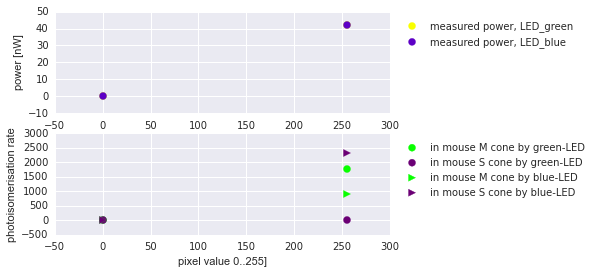

In [21]:
markers = ["o", ">", "<", "#"]

for iLED, LED in enumerate(LEDs):
    colLED = csl.wavelength_to_rgb(LED["peak_nm"])
    plt.subplot(2, 1, 1)
    sns.axlabel("pixel value 0..255]", "power [nW]")         
    plt.scatter(LED["levels"], LED["pow_meas_nW"], color=colLED, label="measured power, LED_" +LED["name"],
                marker="o", s=50)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

    plt.subplot(2, 1, 2)
    sns.axlabel("pixel value 0..255]", "photoisomerisation rate")         
    for iEffect, effect in enumerate(LED["effect_on_PR"]):
        for PR in PRs:
            if PR["name"] == effect["PR_name"]:
                if len(PR["spect"]) > 0:
                    colPR = csl.wavelength_to_rgb(PR["peak_nm"])
                    plt.scatter(LED["levels"], effect["photoiso_rate"], color=colPR, 
                                label="in " +PR["name"] +" by " +LED["name"] +"-LED",
                                marker=markers[iLED], s=50)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")